In [1]:
%matplotlib inline

# from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# Fix the path construction - use forward slashes or raw strings
import os

In [2]:

# Method 1: Use forward slashes (recommended)
path = os.path.abspath(os.path.join("..", "04_S&P500_quant_analysis", "01_data", "S&P500_D_1789-05-01_2025-09-17.csv"))

# Alternative Method 2: Use raw string
# path = os.path.abspath(os.path.join("..", r"04_S&P500_quant_analysis\01_data", "S&P500_D_1789-05-01_2025-09-17.csv"))

# Alternative Method 3: Use pathlib (modern approach)
# from pathlib import Path
# path = Path("..") / "04_S&P500_quant_analysis" / "01_data" / "S&P500_D_1789-05-01_2025-09-17.csv"

print(f"Path exists: {os.path.exists(path)}")

# Read the CSV file
df = pd.read_csv(path)

# lower case column names for easier access
df.columns = [col.lower() for col in df.columns]

# Set the 'date' column as the index and convert it to datetime
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# filter years from 1960
df = df[df.index.year >= 1960]

# Show the first few rows of the dataframe
df.head()

Path exists: True


,open,high,low,close,volume
date,,,,,
1960-01-04,59.91,59.91,59.91,59.91,2216667.0
1960-01-05,60.39,60.39,60.39,60.39,2061111.0
1960-01-06,60.13,60.13,60.13,60.13,2072222.0
1960-01-07,59.69,59.69,59.69,59.69,1838889.0
1960-01-08,59.50,59.50,59.50,59.50,1827778.0


In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [4]:
sns.set_style('whitegrid')
np.random.seed(42)

In [5]:
# results_path = Path('results', 'univariate_time_series')
# if not results_path.exists():
#     results_path.mkdir(parents=True)

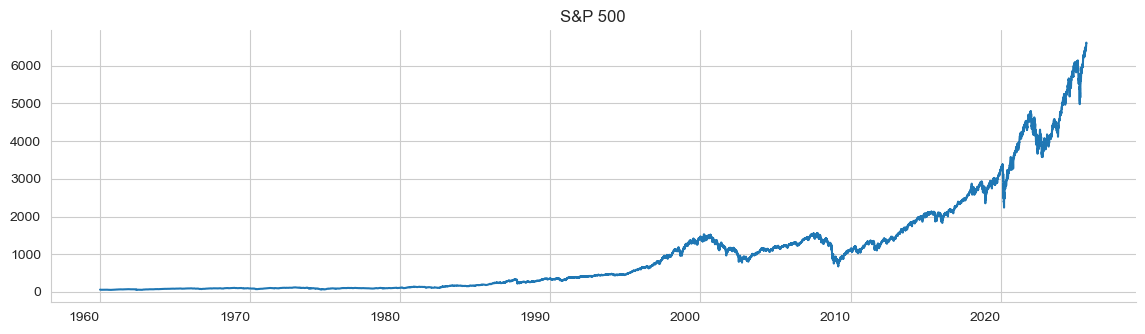

In [6]:
sp500 = df.close.copy()
ax = sp500.plot(title='S&P 500',
           legend=False,
           figsize=(14, 4),
           rot=0)
ax.set_xlabel('')
sns.despine()

In [7]:
scaler = MinMaxScaler()
sp500_scaled = pd.Series(scaler.fit_transform(sp500.values.reshape(-1, 1)).squeeze(), 
                         index=sp500.index)
sp500_scaled.describe()

"""
sp500.values.reshape(-1, 1) converts the Series to a 2D numpy array 
with shape (n_samples, 1)
-1 means "infer the dimension" and 1 means "1 feature column"
.squeeze() converts the 2D result back to 1D for creating the Series
"""

# # Alternative approach
# scaler = MinMaxScaler()
# sp500_scaled = pd.Series(scaler.fit_transform(sp500.to_frame()).squeeze(), 
#                          index=sp500.index)
# sp500_scaled.describe()

'\nsp500.values.reshape(-1, 1) converts the Series to a 2D numpy array \nwith shape (n_samples, 1)\n-1 means "infer the dimension" and 1 means "1 feature column"\n.squeeze() converts the 2D result back to 1D for creating the Series\n'

In [8]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [9]:
"""
X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
This line of code creates a feature matrix X for time series analysis 
using a sliding window approach. 

The core operation uses np.hstack() to horizontally stack multiple arrays together, 
combining them column-wise into a single matrix. 
The arrays being stacked are generated by a list comprehension that creates 
time-lagged versions of the original data.

The list comprehension [data[i: n-j, :] 
for i, j in enumerate(range(window_size, 0, -1))] 
is the heart of this operation. 
It uses enumerate() on a reversed range to create multiple slices of the data array. 
The range(window_size, 0, -1) generates numbers counting down from window_size to 1, 
which determines how many time steps back to look for each feature.

For each iteration, i represents the current index (starting from 0), 
and j represents the countdown value from the range. 
The slicing data[i: n-j, :] extracts a portion of the data starting 
from row i and ending at row n-j, where n is likely the total number 
of time steps. This creates overlapping windows of historical data, 
with each subsequent slice shifted by one time step.

The resulting slices are different lengths due to the varying start and end points, 
but they represent consecutive time windows of the data. 
When these slices are horizontally stacked using np.hstack(), 
they form a feature matrix where each row represents a time point, 
and the columns contain the current value plus lagged values 
from previous time steps. 
This is a common technique in time series regression where 
you want to use historical values as predictive features 
for forecasting future values.

The tuple() wrapper around the list comprehension is required because 
np.hstack() expects a sequence of arrays, 
and converting the list to a tuple ensures compatibility 
with the function's expected input format.
""";

In [10]:
window_size = 63
X, y = create_univariate_rnn_data(sp500_scaled, window_size=window_size)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,53,54,55,56,57,58,59,60,61,62
date,,,,,,,,,,,,,,,,,,,,,
1960-04-01,0.001175,0.001248,0.001208,0.001141,0.001112,0.001001,0.000946,0.000896,0.000945,0.000942,...,0.000428,0.000437,0.000471,0.000539,0.000576,0.000576,0.000558,0.000545,0.000527,0.000478
1960-04-04,0.001248,0.001208,0.001141,0.001112,0.001001,0.000946,0.000896,0.000945,0.000942,0.000867,...,0.000437,0.000471,0.000539,0.000576,0.000576,0.000558,0.000545,0.000527,0.000478,0.000492
1960-04-05,0.001208,0.001141,0.001112,0.001001,0.000946,0.000896,0.000945,0.000942,0.000867,0.000773,...,0.000471,0.000539,0.000576,0.000576,0.000558,0.000545,0.000527,0.000478,0.000492,0.000509
1960-04-06,0.001141,0.001112,0.001001,0.000946,0.000896,0.000945,0.000942,0.000867,0.000773,0.000742,...,0.000539,0.000576,0.000576,0.000558,0.000545,0.000527,0.000478,0.000492,0.000509,0.000483
1960-04-07,0.001112,0.001001,0.000946,0.000896,0.000945,0.000942,0.000867,0.000773,0.000742,0.000763,...,0.000576,0.000576,0.000558,0.000545,0.000527,0.000478,0.000492,0.000509,0.000483,0.000657


In [11]:
y.head()

date
1960-04-01    0.000492
1960-04-04    0.000509
1960-04-05    0.000483
1960-04-06    0.000657
1960-04-07    0.000658
dtype: float64

In [12]:
X.shape

(16474, 63)

In [13]:
y.shape

(16474,)

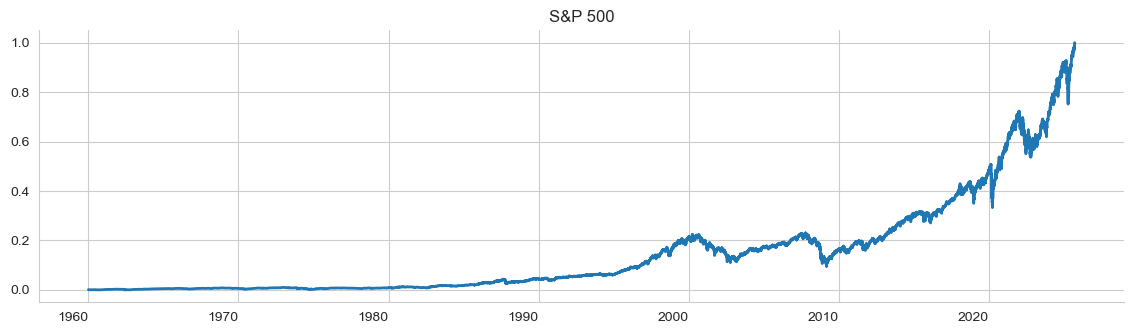

In [14]:
ax = sp500_scaled.plot(title='S&P 500',
           legend=False, 
           lw=2, 
           figsize=(14, 4), 
           rot=0)
ax.set_xlabel('')
sns.despine()

In [15]:
X_train = X[:'2020'].values.reshape(-1, window_size, 1)
y_train = y[:'2020']

# keep the last year for testing
X_test = X['2021'].values.reshape(-1, window_size, 1)
y_test = y['2021']

n_obs, window_size, n_features = X_train.shape

y_train.shape

(15292,)

In [16]:
rnn = Sequential([
    LSTM(units=10, 
         input_shape=(window_size, n_features), name='LSTM'),
    Dense(1, name='Output')
])


rnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ LSTM (LSTM)                     │ (None, 10)             │           480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output (Dense)                  │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 491 (1.92 KB)

 Trainable params: 491 (1.92 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001,
                                     rho=0.9,
                                     epsilon=1e-08)
rnn.compile(loss='mean_squared_error', 
            optimizer=optimizer)

In [21]:
from pathlib import Path

results_path = Path('results', 'univariate_time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

rnn_path = (results_path / 'rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path,
                               verbose=1,
                               monitor='val_loss',
                               save_best_only=True)

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=20,
                              restore_best_weights=True)

In [23]:
lstm_training = rnn.fit(X_train,
                        y_train,
                        epochs=150,
                        batch_size=20,
                        shuffle=True,
                        validation_data=(X_test, y_test),
                        callbacks=[early_stopping, checkpointer],
                        verbose=1)

Epoch 1/150
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0041
Epoch 1: val_loss improved from None to 0.00042, saving model to results/univariate_time_series/rnn.h5


765/765 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 9.6977e-04 - val_loss: 4.1758e-04
Epoch 2/150
764/765 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.9204e-05
Epoch 2: val_loss improved from 0.00042 to 0.00030, saving model to results/univariate_time_series/rnn.h5


765/765 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 2.7341e-05 - val_loss: 2.9689e-04
Epoch 3/150
758/765 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5590e-05
Epoch 3: val_loss improved from 0.00030 to 0.00013, saving model to results/univariate_time_series/rnn.h5


765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 2.2222e-05 - val_loss: 1.2999e-04
Epoch 4/150
762/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9105e-05
Epoch 4: val_loss improved from 0.00013 to 0.00012, saving model to results/univariate_time_series/rnn.h5


765/765 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 1.8974e-05 - val_loss: 1.1645e-04
Epoch 5/150
762/765 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6932e-05
Epoch 5: val_loss did not improve from 0.00012
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.7036e-05 - val_loss: 0.0011
Epoch 6/150
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6346e-05
Epoch 6: val_loss did not improve from 0.00012
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.5841e-05 - val_loss: 1.3100e-04
Epoch 7/150
758/765 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5234e-05
Epoch 7: val_loss improved from 0.00012 to 0.00008, saving model to results/univariate_time_series/rnn.h5


765/765 ━━━━━━━━━━━━━━━━━━━━ 10s 7ms/step - loss: 1.3931e-05 - val_loss: 7.7640e-05
Epoch 8/150
759/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4205e-05
Epoch 8: val_loss did not improve from 0.00008
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 1.3797e-05 - val_loss: 1.0478e-04
Epoch 9/150
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3099e-05
Epoch 9: val_loss did not improve from 0.00008
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.2965e-05 - val_loss: 1.6181e-04
Epoch 10/150
759/765 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2150e-05
Epoch 10: val_loss improved from 0.00008 to 0.00006, saving model to results/univariate_time_series/rnn.h5


765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.2215e-05 - val_loss: 6.1526e-05
Epoch 11/150
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2561e-05
Epoch 11: val_loss improved from 0.00006 to 0.00005, saving model to results/univariate_time_series/rnn.h5


765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 1.1897e-05 - val_loss: 4.5232e-05
Epoch 12/150
760/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0989e-05
Epoch 12: val_loss did not improve from 0.00005
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 1.1452e-05 - val_loss: 8.4174e-05
Epoch 13/150
758/765 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1170e-05
Epoch 13: val_loss did not improve from 0.00005
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.1076e-05 - val_loss: 6.8223e-05
Epoch 14/150
758/765 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1046e-05 
Epoch 14: val_loss did not improve from 0.00005
765/765 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 1.0930e-05 - val_loss: 5.7661e-05
Epoch 15/150
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0615e-05
Epoch 15: val_loss did not improve from 0.00005
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1.0320e-05 - val_loss: 5.1509e-05
Epoch 16/150
761/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1106e-05
Epoch 16: val_loss improve

765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 1.0349e-05 - val_loss: 4.1386e-05
Epoch 17/150
762/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.2351e-06
Epoch 17: val_loss did not improve from 0.00004
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 9.9742e-06 - val_loss: 4.3646e-05
Epoch 18/150
761/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.7106e-06
Epoch 18: val_loss did not improve from 0.00004
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 9.6614e-06 - val_loss: 4.4637e-04
Epoch 19/150
762/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.9047e-06
Epoch 19: val_loss improved from 0.00004 to 0.00004, saving model to results/univariate_time_series/rnn.h5


765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 9.3822e-06 - val_loss: 4.0421e-05
Epoch 20/150
760/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.8270e-06
Epoch 20: val_loss improved from 0.00004 to 0.00004, saving model to results/univariate_time_series/rnn.h5


765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 9.3437e-06 - val_loss: 3.9682e-05
Epoch 21/150
759/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.6579e-06
Epoch 21: val_loss did not improve from 0.00004
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 9.1214e-06 - val_loss: 9.1566e-05
Epoch 22/150
759/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.8085e-06
Epoch 22: val_loss did not improve from 0.00004
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 9.1533e-06 - val_loss: 6.7899e-05
Epoch 23/150
763/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.3300e-06
Epoch 23: val_loss did not improve from 0.00004
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 9.0080e-06 - val_loss: 6.2911e-05
Epoch 24/150
761/765 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.0360e-06
Epoch 24: val_loss did not improve from 0.00004
765/765 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 8.7423e-06 - val_loss: 8.3420e-05
Epoch 25/150
763/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.4212e-06
Epoch 25: val_loss did not

765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 8.3191e-06 - val_loss: 3.6186e-05
Epoch 28/150
763/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.7495e-06
Epoch 28: val_loss did not improve from 0.00004
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 8.2870e-06 - val_loss: 4.0260e-05
Epoch 29/150
760/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.8807e-06
Epoch 29: val_loss did not improve from 0.00004
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 8.1265e-06 - val_loss: 5.5601e-05
Epoch 30/150
763/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.9707e-06
Epoch 30: val_loss did not improve from 0.00004
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 8.2098e-06 - val_loss: 3.6938e-05
Epoch 31/150
761/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 8.2742e-06
Epoch 31: val_loss did not improve from 0.00004
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 7.9872e-06 - val_loss: 4.0054e-05
Epoch 32/150
762/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.4456e-06
Epoch 32: val_loss did not i

765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 7.6104e-06 - val_loss: 3.4352e-05
Epoch 38/150
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.6132e-06
Epoch 38: val_loss did not improve from 0.00003
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 7.5796e-06 - val_loss: 7.1681e-05
Epoch 39/150
764/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.1610e-06
Epoch 39: val_loss did not improve from 0.00003
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 7.3764e-06 - val_loss: 1.4184e-04
Epoch 40/150
760/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.4045e-06
Epoch 40: val_loss did not improve from 0.00003
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 7.4301e-06 - val_loss: 5.9251e-05
Epoch 41/150
761/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.3103e-06
Epoch 41: val_loss did not improve from 0.00003
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 7.3388e-06 - val_loss: 4.6465e-05
Epoch 42/150
762/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 7.1257e-06
Epoch 42: val_loss did not i

765/765 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 6.7685e-06 - val_loss: 3.4219e-05
Epoch 55/150
763/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.6120e-06
Epoch 55: val_loss improved from 0.00003 to 0.00003, saving model to results/univariate_time_series/rnn.h5


765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 6.7006e-06 - val_loss: 3.3654e-05
Epoch 56/150
764/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.3292e-06
Epoch 56: val_loss did not improve from 0.00003
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 6.6639e-06 - val_loss: 6.5727e-05
Epoch 57/150
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.0119e-06
Epoch 57: val_loss did not improve from 0.00003
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 6.6791e-06 - val_loss: 5.5298e-05
Epoch 58/150
761/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.4116e-06
Epoch 58: val_loss improved from 0.00003 to 0.00003, saving model to results/univariate_time_series/rnn.h5


765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 6.6020e-06 - val_loss: 3.2603e-05
Epoch 59/150
761/765 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.4337e-06
Epoch 59: val_loss did not improve from 0.00003
765/765 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 6.6576e-06 - val_loss: 8.9656e-05
Epoch 60/150
764/765 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.7208e-06
Epoch 60: val_loss did not improve from 0.00003
765/765 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 6.5937e-06 - val_loss: 9.8309e-05
Epoch 61/150
764/765 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.0759e-06
Epoch 61: val_loss did not improve from 0.00003
765/765 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 6.4561e-06 - val_loss: 3.3874e-05
Epoch 62/150
761/765 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 6.3810e-06
Epoch 62: val_loss did not improve from 0.00003
765/765 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - loss: 6.5507e-06 - val_loss: 3.6599e-05
Epoch 63/150
761/765 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.8143e-06
Epoch 63: val_loss did n

765/765 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 6.5732e-06 - val_loss: 3.2260e-05
Epoch 65/150
764/765 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.0417e-06
Epoch 65: val_loss did not improve from 0.00003
765/765 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 6.3625e-06 - val_loss: 3.8495e-05
Epoch 66/150
758/765 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.8644e-06
Epoch 66: val_loss did not improve from 0.00003
765/765 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 6.3901e-06 - val_loss: 4.0047e-05
Epoch 67/150
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.3811e-06
Epoch 67: val_loss did not improve from 0.00003
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 6.4631e-06 - val_loss: 3.8581e-05
Epoch 68/150
761/765 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.6004e-06
Epoch 68: val_loss did not improve from 0.00003
765/765 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 6.3528e-06 - val_loss: 3.2340e-05
Epoch 69/150
763/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.3472e-06
Epoch 69: val_loss did n

765/765 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 6.2781e-06 - val_loss: 3.1994e-05
Epoch 75/150
764/765 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 6.3546e-06
Epoch 75: val_loss did not improve from 0.00003
765/765 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - loss: 6.2494e-06 - val_loss: 3.2743e-05
Epoch 76/150
765/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.3949e-06
Epoch 76: val_loss did not improve from 0.00003
765/765 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 6.2062e-06 - val_loss: 3.2561e-05
Epoch 77/150
761/765 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.2121e-06
Epoch 77: val_loss did not improve from 0.00003
765/765 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 6.1538e-06 - val_loss: 3.8046e-05
Epoch 78/150
761/765 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.4968e-06
Epoch 78: val_loss did not improve from 0.00003
765/765 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 6.2137e-06 - val_loss: 3.8351e-05
Epoch 79/150
763/765 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.0395e-06
Epoch 79: val_loss did n

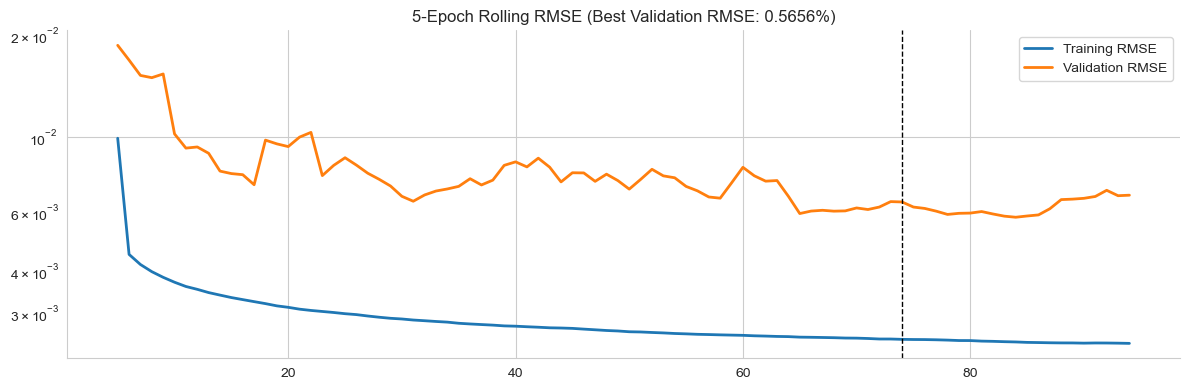

In [24]:
# Evaluate model performance
fig, ax = plt.subplots(figsize=(12, 4))

loss_history = pd.DataFrame(lstm_training.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_sp500_error', dpi=300);

In [25]:
train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

train_predict_scaled = rnn.predict(X_train)
test_predict_scaled = rnn.predict(X_test)
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train RMSE: 0.0023 | Test RMSE: 0.0057
478/478 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Train IC: 0.9999 | Test IC: 0.9885


In [28]:
# # Rescale predictions
# train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
# test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled)
#                           .squeeze(), 
#                           index=y_test.index))
# y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
# y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()
# train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
# test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
# f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'

# sp500['Train Predictions'] = train_predict
# sp500['Test Predictions'] = test_predict
# sp500 = sp500.join(train_predict.to_frame('predictions').assign(data='Train')
#                         .append(test_predict.to_frame('predictions').assign(data='Test')))

In [29]:
# Rescale predictions
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled)
                          .squeeze(), 
                          index=y_test.index))
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
print(f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}')

# Convert to DataFrame and add predictions
sp500_df = sp500.to_frame('actual')
sp500_df['Train Predictions'] = train_predict
sp500_df['Test Predictions'] = test_predict

# Create combined predictions DataFrame using concat instead of append
train_pred_df = train_predict.to_frame('predictions').assign(data='Train')
test_pred_df = test_predict.to_frame('predictions').assign(data='Test')
combined_predictions = pd.concat([train_pred_df, test_pred_df])

sp500_df = sp500_df.join(combined_predictions)

Train RMSE: 15.30 | Test RMSE: 37.12


In [31]:
# # Plot Results
# fig=plt.figure(figsize=(14,7))
# ax1 = plt.subplot(221)

# sp500.loc['2015':, 'SP500'].plot(lw=4, ax=ax1, c='k')
# sp500.loc['2015':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
# ax1.set_title('In- and Out-of-sample Predictions')


# with sns.axes_style("white"):
#     ax3 = plt.subplot(223)
#     sns.scatterplot(x='SP500', y='predictions', data=sp500, hue='data', ax=ax3)
#     ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
#     ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
#     ax3.set_title('Correlation')
#     ax3.legend(loc='lower right')
    
#     ax2 = plt.subplot(222)
#     ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
#     sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
#     ax2.set_title('Train Error')
#     ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
#     sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
#     ax4.set_title('Test Error')
#     ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

# sns.despine()
# fig.tight_layout()
# fig.savefig(results_path / 'rnn_sp500_regression', dpi=300);

In [37]:
# Create a completely clean DataFrame structure
sp500_clean = pd.DataFrame({
    'actual': sp500,
    'Train_Predictions': pd.Series(dtype='float64', index=sp500.index),
    'Test_Predictions': pd.Series(dtype='float64', index=sp500.index)
})

# Add predictions to the appropriate rows
sp500_clean.loc[train_predict.index, 'Train_Predictions'] = train_predict
sp500_clean.loc[test_predict.index, 'Test_Predictions'] = test_predict

# Create separate scatter plot data
train_scatter = pd.DataFrame({
    'actual': sp500.loc[train_predict.index],
    'predictions': train_predict.values,
    'data': 'Train'
})

test_scatter = pd.DataFrame({
    'actual': sp500.loc[test_predict.index],
    'predictions': test_predict.values,
    'data': 'Test'
})

scatter_data = pd.concat([train_scatter, test_scatter], ignore_index=True)

print("Data range:", sp500_clean.index.min(), "to", sp500_clean.index.max())
print("Available years:", sorted(sp500_clean.index.year.unique()))

# Plot Results
fig = plt.figure(figsize=(14, 7))
ax1 = plt.subplot(221)

# Use year-based filtering
recent_data = sp500_clean[sp500_clean.index.year >= 2010]
recent_data['actual'].plot(lw=4, ax=ax1, c='k', label='Actual')
recent_data[['Test_Predictions', 'Train_Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')
ax1.legend()

with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='actual', y='predictions', data=scatter_data, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex=ax2, sharey=ax2)
    sns.histplot(train_predict.squeeze() - y_train_rescaled, ax=ax2, kde=True)  
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.histplot(test_predict.squeeze() - y_test_rescaled, ax=ax4, kde=True)  
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_sp500_regression', dpi=300)
plt.show()

TypeError: '<=' not supported between instances of 'Timestamp' and 'str'